In [132]:
import sys
import os
import warnings
import pandas as pd
import numpy as np
import random

# Add the root directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('weld_quality_prediction'), '..')))

from data_preprocessing.functions import replace_data, choose_labels, pipeline_training_set
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [133]:
data = pd.read_csv('../data/welddb.data', sep=' ', header=None)

column_names = [
    "Carbon_concentration",
    "Silicon_concentration",
    "Manganese_concentration",
    "Sulphur_concentration",
    "Phosphorus_concentration",
    "Nickel_concentration",
    "Chromium_concentration",
    "Molybdenum_concentration",
    "Vanadium_concentration",
    "Copper_concentration",
    "Cobalt_concentration",
    "Tungsten_concentration",
    "Oxygen_concentration",
    "Titanium_concentration",
    "Nitrogen_concentration",
    "Aluminium_concentration",
    "Boron_concentration",
    "Niobium_concentration",
    "Tin_concentration",
    "Arsenic_concentration",
    "Antimony_concentration",
    "Current",
    "Voltage",
    "AC_or_DC",
    "Electrode_positive_or_negative",
    "Heat_input",
    "Interpass_temperature",
    "Type_of_weld",
    "Post_weld_heat_treatment_temperature",
    "Post_weld_heat_treatment_time",
    "Yield_strength",
    "Ultimate_tensile_strength",
    "Elongation",
    "Reduction_of_Area",
    "Charpy_temperature",
    "Charpy_impact_toughness",
    "Hardness",
    "50%_FATT",
    "Primary_ferrite_in_microstructure",
    "Ferrite_with_second_phase",
    "Acicular_ferrite",
    "Martensite",
    "Ferrite_with_carbide_aggregate",
    "Weld_ID"
]

sulphur_and_phosphorus_columns = ["Sulphur_concentration","Phosphorus_concentration"]

other_concentration_columns = ["Carbon_concentration",
        "Silicon_concentration",
        "Manganese_concentration",
        "Nickel_concentration",
        "Chromium_concentration",
        "Molybdenum_concentration",
        "Vanadium_concentration",
        "Copper_concentration",
        "Cobalt_concentration",
        "Tungsten_concentration",
        "Oxygen_concentration",
        "Titanium_concentration",
        "Nitrogen_concentration",
        'Nitrogen_concentration_residual',
        "Aluminium_concentration",
        "Boron_concentration",
        "Niobium_concentration",
        "Tin_concentration",
        "Arsenic_concentration",
        "Antimony_concentration"]

label_names = ['Yield_strength', 'Ultimate_tensile_strength', 'Elongation', 'Reduction_of_Area', 'Charpy_temperature', 
                   'Charpy_impact_toughness', 'Hardness', '50%_FATT', 'Primary_ferrite_in_microstructure', 'Ferrite_with_second_phase', 
                   'Acicular_ferrite', 'Martensite', 'Ferrite_with_carbide_aggregate', 'Hardness_load']

physical_ordinal_properties_columns = [
        'Current', 
        'Voltage',
        'Heat_input',
        'Interpass_temperature',
        'Post_weld_heat_treatment_temperature',
        'Post_weld_heat_treatment_time', 
    ]

physical_categorical_properties_columns = [
    'AC_or_DC',
    'Electrode_positive_or_negative',
    'Type_of_weld'
]

data.columns = column_names

In [134]:
# Suppress all FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

#Selection of the targets
labels_selected = ["Yield_strength"]

#Replace 'N' value with Nan
data = replace_data(data)

#Selection fof the data for supervised learning
data_with_label = data.copy()
data_with_label = data[data_with_label[labels_selected].notna().all(axis=1)]

#Separation of features and labels
X, y = choose_labels(data_with_label, labels_chosen=labels_selected)


# Neural Network

## Model

In [135]:
# Neural network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Define the neural network
class Net(nn.Module):
    def __init__(self, layers, n_layers, activation=nn.ReLU):
        super(Net, self).__init__()
        self.n_layers = n_layers
        self.activation = activation
        for i in range(n_layers):
            setattr(self, f'fc{i}', nn.Linear(layers[i][0], layers[i][1]))

    def forward(self, x):
        for i in range(self.n_layers):
            x = getattr(self, f'fc{i}')(x)
            x = self.activation()(x)
        return x
    


In [136]:
# Training

def train_loop(dataloader, model, loss_fn, optimizer, batch_size, visualize=False):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        
        #  Reset the gradients to zero
        optimizer.zero_grad()

        # Print the progress of the training
        if batch % 10 == 0 and batch != 0 and visualize == True:
            loss, current = np.sqrt(loss.item() / dataloader.batch_size), batch * batch_size + len(X)
            print(f"Mean loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn, visualize=False):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= ( num_batches * dataloader.batch_size )
    if visualize == True:
        print(f"Test Error: \n Avg loss: {np.sqrt(test_loss):>8f} \n")
    return np.sqrt(test_loss)

In [137]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y

In [145]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42)

# Define the learning rate
lr = 0.001

# Define the number of epochs
n_epochs = 15

# Define the batch size
batch_size = 4

# Layers
layer_def = [16, 8]

# Parameters
categorical_strategy="logistic"
ordinal_strategy="linear"
is_PCA=True
pca_percent_explained_variance=0.85
pca_columns="all_ordinals"


def create_and_train(X_train, X_test, y_train, y_test, layer_def, ordinal_strategy, categorical_strategy, pca_percent_explained_variance, 
                     pca_columns, activation, lr, n_epochs, batch_size, scaler_strategy="standard", visualize=False):
    # Preprocess the data
    X_train, X_test, y_train, y_test = pipeline_training_set(training_set=X_train, training_labels=y_train, testing_set=X_test, testing_labels=y_test, 
                                                            labels_chosen=labels_selected, categorical_strategy=categorical_strategy, \
                                                            ordinal_strategy=ordinal_strategy, is_PCA=is_PCA, 
                                                            pca_percent_explained_variance=pca_percent_explained_variance, 
                                                            scaler_strategy=scaler_strategy, pca_columns=pca_columns, less_than_strategy="mean")

    # Get the input size
    input_size = X_train.shape[1]


    # Convert the data to PyTorch tensors
    X_train = torch.tensor(X_train.values, dtype=torch.float32)
    X_test = torch.tensor(X_test.values, dtype=torch.float32)
    y_train = torch.tensor(y_train.values, dtype=torch.float32)
    y_test = torch.tensor(y_test.values, dtype=torch.float32)

    # Set the seed for reproducibility
    seed = 42
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Define the model
    activation = activation
    n_layers = len(layer_def)
    layers = [(input_size, layer_def[0])]
    for i in range(1, n_layers):
        layers.append((layer_def[i-1], layer_def[i]))
    layers.append((layer_def[n_layers-1], 1))
    
    model = Net(layers, n_layers+1, activation=activation)

    # Define the loss function
    loss_fn = nn.MSELoss()

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Create the dataset
    train_dataset = CustomDataset(X_train, y_train)
    test_dataset = CustomDataset(X_test, y_test)

    # Create the dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    # Train the model
    for t in range(n_epochs):
        if visualize == True:
            print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer, batch_size, visualize=visualize)
    return model, X_test, y_test, test_dataloader, loss_fn

model, X_test, y_test, test_dataloader, loss_fn = create_and_train(X_train, X_test, y_train, y_test, layer_def, ordinal_strategy, categorical_strategy, 
                                          pca_percent_explained_variance, pca_columns, nn.ReLU, lr, n_epochs, batch_size, visualize=True)

Number of components chosen by PCA: 16
Explained Variance Ratio: [0.1417783  0.13096131 0.07509128 0.06767513 0.05919526 0.04746247
 0.04326758 0.03816442 0.03698318 0.03537689 0.03304419 0.03132463
 0.02997622 0.02779311 0.02664962 0.02609292]
Epoch 1
-------------------------------
Mean loss: 244.864344  [   44/  702]
Mean loss: 245.795949  [   84/  702]
Mean loss: 261.466253  [  124/  702]
Mean loss: 267.363590  [  164/  702]
Mean loss: 269.673385  [  204/  702]
Mean loss: 221.608995  [  244/  702]
Mean loss: 203.474229  [  284/  702]
Mean loss: 236.201946  [  324/  702]
Mean loss: 248.556300  [  364/  702]
Mean loss: 235.241988  [  404/  702]
Mean loss: 250.141140  [  444/  702]
Mean loss: 253.556161  [  484/  702]
Mean loss: 242.853093  [  524/  702]
Mean loss: 223.796486  [  564/  702]
Mean loss: 233.640783  [  604/  702]
Mean loss: 275.107422  [  644/  702]
Mean loss: 261.096277  [  684/  702]
Epoch 2
-------------------------------
Mean loss: 244.140328  [   44/  702]
Mean loss

In [139]:
# Test the model
test_loop(test_dataloader, model, loss_fn, visualize=True)

Test Error: 
 Avg loss: 46.334558 



46.33455793468505

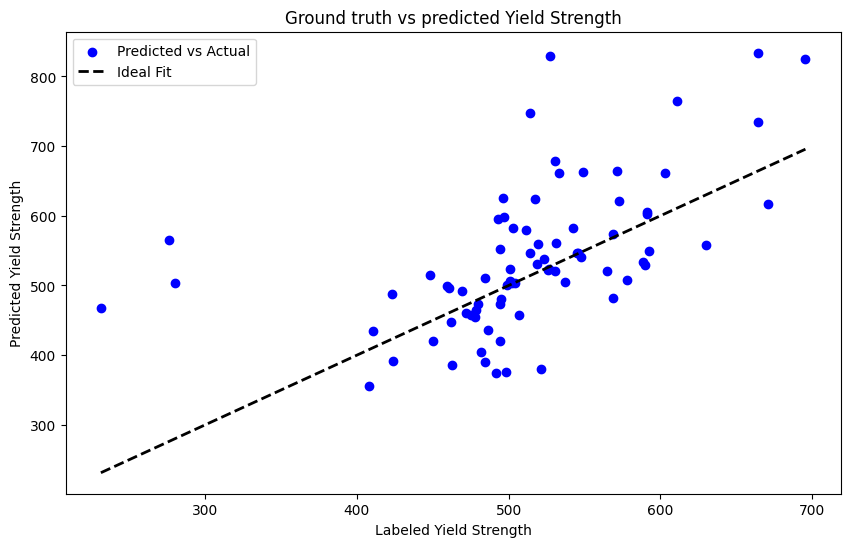

In [140]:
import matplotlib.pyplot as plt

new_y_test = model(X_test).detach().numpy()

# Convert new_y_test to a numpy array for plotting
new_y_test_values = new_y_test

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(new_y_test_values, y_test.detach().numpy(), color='blue', label='Predicted vs Actual')
plt.plot([new_y_test_values.min(), new_y_test_values.max()], [new_y_test_values.min(), new_y_test_values.max()], 'k--', lw=2, label='Ideal Fit')
plt.xlabel('Labeled Yield Strength')
plt.ylabel('Predicted Yield Strength')
plt.title('Ground truth vs predicted Yield Strength')
plt.legend()
plt.show()

## Finding best hyperparameters with grid Search 
Training, Validation and Test Set

In [142]:
from itertools import product

# Suppress all warnings
warnings.filterwarnings("ignore")

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42)

# Grid Search

# Define the learning rate
lr = [0.001, 0.01]
# Define the number of epochs
n_epochs = [10, 15]
# Define the batch size
batch_size = [4, 8] 
# Activation functions
activation = nn.ReLU

# Layers
layer_def = [[16, 8], [32, 16], [16, 8, 4]]
# Parameters
categorical_strategy = ["logistic", "most_frequent"]
ordinal_strategy = ["linear", "mean"]
is_PCA = [True]
pca_percent_explained_variance = [0.85, 0.9]
pca_columns = ["all_ordinals", "concentration"]

parameters = {
    "lr": lr, 
    "n_epochs": n_epochs, 
    "batch_size": batch_size, 
    "layer_def": layer_def, 
    "ordinal_strategy": ordinal_strategy, 
    "categorical_strategy": categorical_strategy, 
    "is_PCA": is_PCA, 
    "pca_percent_explained_variance": pca_percent_explained_variance, 
    "pca_columns": pca_columns
}

best_model = None
best_score = float('inf')
best_parameters = {"lr": None, 
    "n_epochs": None, 
    "batch_size": None, 
    "layer_def": None, 
    "ordinal_strategy": None, 
    "categorical_strategy": None, 
    "is_PCA": None, 
    "pca_percent_explained_variance": None, 
    "pca_columns": None
}

# K-Cross Validation
from sklearn.model_selection import KFold
n_splits = 3
kf = KFold(n_splits=n_splits, random_state=None, shuffle=False)

# Grid Search
for lr, n_epochs, batch_size, layer_def, ordinal_strategy, categorical_strategy, is_PCA, pca_percent_explained_variance, pca_columns in product(
    parameters["lr"], 
    parameters["n_epochs"], 
    parameters["batch_size"], 
    parameters["layer_def"], 
    parameters["ordinal_strategy"], 
    parameters["categorical_strategy"], 
    parameters["is_PCA"], 
    parameters["pca_percent_explained_variance"], 
    parameters["pca_columns"]
):
    print(f"Testing combination: lr={lr}, n_epochs={n_epochs}, batch_size={batch_size}, layer_def={layer_def}, ordinal_strategy={ordinal_strategy}, categorical_strategy={categorical_strategy}, is_PCA={is_PCA}, pca_percent_explained_variance={pca_percent_explained_variance}, pca_columns={pca_columns}")
    # Add your model training and evaluation code here
    # For example:
    # model, X_test, y_test, test_dataloader, loss_fn = create_and_train(X_train, X_test, y_train, y_test, layer_def, ordinal_strategy, categorical_strategy, pca_percent_explained_variance, pca_columns, nn.ReLU, lr, n_epochs, batch_size)
    # scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
    # rmse_scores = np.sqrt(-scores)
    # score = rmse_scores.mean()
    # if score < best_score:
    #     best_score = score
    #     best_model = model
    #     best_pca_percent_explained_variance = pca_percent_explained_variance  
    
    score = 0
    
    # K-Fold Cross Validation ">
    for train_index, test_index in kf.split(X_train):
        X_train_k, X_test_k = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_k, y_test_k = y_train.iloc[train_index], y_train.iloc[test_index]
        
        model, current_X_test, current_y_test, test_dataloader, loss_fn = create_and_train(X_train_k, X_test_k, y_train_k, y_test_k, 
                                                        layer_def, ordinal_strategy, categorical_strategy, 
                                                        pca_percent_explained_variance, pca_columns, activation, 
                                                        lr, n_epochs, batch_size, visualize=False)  
        
        score += test_loop(test_dataloader, model, loss_fn)
        
    score /= n_splits
    print("\n Mean Scores: ", score, "\n")
    if score < best_score:
        best_score = score
        best_model = model
        best_parameters["lr"] = lr
        best_parameters["n_epochs"] = n_epochs
        best_parameters["batch_size"] = batch_size
        best_parameters["layer_def"] = layer_def
        best_parameters["ordinal_strategy"] = ordinal_strategy
        best_parameters["categorical_strategy"] = categorical_strategy
        best_parameters["is_PCA"] = is_PCA
        best_parameters["pca_percent_explained_variance"] = pca_percent_explained_variance
        best_parameters["pca_columns"] = pca_columns

print("Best parameters: ", best_parameters)
print("Best score: ", best_score)


Testing combination: lr=0.001, n_epochs=10, batch_size=4, layer_def=[16, 8], ordinal_strategy=linear, categorical_strategy=logistic, is_PCA=True, pca_percent_explained_variance=0.85, pca_columns=all_ordinals
Number of components chosen by PCA: 16
Explained Variance Ratio: [0.14124514 0.11684017 0.07831552 0.07126495 0.06010055 0.05008298
 0.04471725 0.04033551 0.03757284 0.03588449 0.03508441 0.03370844
 0.03048282 0.02804174 0.02570812 0.02527942]
Number of components chosen by PCA: 16
Explained Variance Ratio: [0.16184649 0.13536007 0.07758063 0.06873089 0.06025931 0.04919952
 0.04544458 0.03950561 0.03602093 0.03523087 0.03238266 0.0284746
 0.02740267 0.02702554 0.02522546 0.02153329]
Number of components chosen by PCA: 16
Explained Variance Ratio: [0.15386268 0.13731556 0.07420164 0.06373325 0.05773615 0.04527613
 0.04182582 0.03711507 0.03619891 0.03418845 0.03240258 0.02953037
 0.02920001 0.02784653 0.02657525 0.0247172 ]

 Mean Scores:  60.24972704177054 

Testing combination: l

In [148]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42)

# Best parameters
best_parameters = {'lr': 0.01, 'n_epochs': 15, 'batch_size': 8, 'layer_def': [16, 8], 'ordinal_strategy': 'mean', 'categorical_strategy': 'logistic', 'is_PCA': True, 'pca_percent_explained_variance': 0.9, 'pca_columns': 'all_ordinals'}
best_score = 36.06642634257234

best_model, best_X_test, best_y_test, best_test_dataloader, best_loss_fn = create_and_train(X_train, X_test, y_train, y_test, 
                                                        best_parameters["layer_def"], best_parameters["ordinal_strategy"], 
                                                        best_parameters["categorical_strategy"], 
                                                        best_parameters["pca_percent_explained_variance"], 
                                                        best_parameters["pca_columns"], nn.ReLU, 
                                                        best_parameters["lr"], best_parameters["n_epochs"], 
                                                        best_parameters["batch_size"], scaler_strategy="standard", visualize=False) 

mse = test_loop(best_test_dataloader, best_model, best_loss_fn, visualize=True)
print(mse)

Number of components chosen by PCA: 19
Explained Variance Ratio: [0.1401007  0.13035263 0.07460842 0.06807498 0.05929646 0.04748759
 0.04286372 0.03798372 0.03654038 0.0350019  0.03306078 0.03129101
 0.0300361  0.02788558 0.02720405 0.02613335 0.02279037 0.02147058
 0.0165102 ]
Test Error: 
 Avg loss: 29.134066 

29.13406592465676


## Best hyperparameters for neural network

- PCA percent explained variance = 0.9

- PCA columns: all ordinals

- Validation MSE = 36.06642634257234

- Learning rate: 0.01

- Number of epochs: 15

- Batch size: 8

- Layers: 2 hidden layers of 16 and 8 neurones each

- Ordinal strategy: mean

- Categorical strategy: logistic

- MSE on test set: 29.447268280638436

- Scaler: standardization


<div class="alert alert-block alert-success">
<b> Explanation </b>

- Using PCA approach help getting rid of outliers

</div>